### 神经网络反向传播

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
def load_data(path,transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')
    y = y.reshape(y.shape[0])

    X = data.get('X')

    if transpose:
        X = np.array([im.reshape((20,20)).T for im in X])
        X = np.array([im.reshape(400) for im in X])
    return X,y
X,_ = load_data('ex4data1.mat')


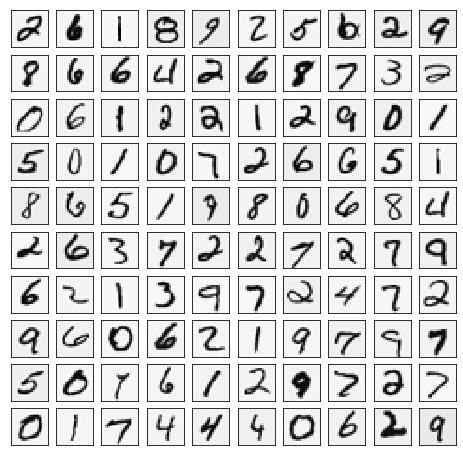

In [4]:
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1]))
    sample_idx = np.random.choice(np.arange(X.shape[0]),100)
    sample_images = X[sample_idx,:]
    fig,ax_array = plt.subplots(nrows=10,ncols=10,sharey=True,sharex=True,figsize=(8,8))
    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_images[10*r+c].reshape((size,size)),cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
plot_100_image(X)
plt.show()

In [5]:
X_raw,y_raw = load_data('ex4data1.mat',transpose=False)
X = np.insert(X_raw,0,np.ones(X_raw.shape[0]),axis=1)
X.shape

(5000, 401)

In [7]:
def expand_y(y):
    res = []
    for i in y:
        y_array = np.zeros(10)
        y_array[i-1] = 1
        res.append(y_array)
    return np.array(res)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse=False)
# y_onehot = encoder.fit_transform(y)
# y_onehot.shape #这个函数与expand_y(y)一致
y = expand_y(y_raw)

In [10]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'],data['Theta2']
t1,t2 = load_weight('ex4weights.mat')
t1.shape,t2.shape

((25, 401), (10, 26))

In [12]:
# 扁平化
def serialize(a,b):
    return np.concatenate((np.ravel(a),np.ravel(b)))
theta = serialize(t1,t2)
theta.shape

(10285,)

### 向前传播

In [13]:
# 去扁平化
def deserialize(seq):
    return seq[:25*401].reshape(25,401),seq[25*401:].reshape(10,26)

# 激活函数
def sigmoid(z):
    return 1/(1+np.exp(-z))

def feed_forward(theta,X):

    t1,t2 = deserialize(theta) # t1: (25,401) t2: (10,26)
    m = X.shape[0] #5000
    a1 = X # 5000*401
 
    z2 = a1 @ t1.T # 5000*25
    a2 = np.insert(sigmoid(z2),0,np.ones(m),axis=1) # 5000*26

    z3 = a2 @ t2.T # 5000*10
    h = sigmoid(z3)

    return a1,z2,a2,z3,h

_, _, _, _, h = feed_forward(theta,X)
h


array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

### cost function

In [14]:
def cost(theta,X,y):
    m = X.shape[0]
    _,_,_,_,h = feed_forward(theta,X)
    pair_computation = -np.multiply(y,np.log(h))-np.multiply((1-y),np.log(1-h))
    return pair_computation.sum()/m
cost(theta,X,y)


0.2876291651613189

## 正则化损失函数

In [15]:
def regularized_cost(theta,X,y,l=1):
    t1,t2 = deserialize(theta)
    m = X.shape[0]
    reg_t1 = (1/(2*m))*np.power(t1[:,1:],2).sum()
    reg_t2 = (1/(2*m))*np.power(t2[:,1:],2).sum()
    return cost(theta,X,y)+reg_t1+reg_t2
regularized_cost(theta,X,y)

0.38376985909092365

#### back propagation

In [17]:
X.shape,y.shape,theta.shape

((5000, 401), (5000, 10), (10285,))

In [19]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z),1-sigmoid(z))

In [20]:
def gradient(theta,X,y):
    t1,t2 = deserialize(theta)
    m = X.shape[0]

    delta1 = np.zeros(t1.shape)
    delta2 = np.zeros(t2.shape)

    a1,z2,a2,z3,h = feed_forward(theta,X)

    for i in range(m):
        a1i = a1[i,:] #(1,401)
        z2i = z2[i,:] #(1,25)
        a2i = a2[i,:] #(1,26)

        hi = h[i,:] #(1,10)
        yi = y[i,:] #(1,10)

        d3i = hi - yi #(1,10)
        z2i = np.insert(z2i,0,np.ones(1))
        d2i = np.multiply(t2.T @ d3i,sigmoid_gradient(z2i))

        delta2 += np.matrix(d3i).T @ np.matrix(a2i)
        delta1 += np.matrix(d2i[1:]).T @ np.matrix(a1i)
    delta1 = delta1 / m
    delta2 = delta2 / m
    return serialize(delta1,delta2)

def regularized_gradient(theta,X,y,l=1):
    m = X.shape[0]
    delta1,delta2 = deserialize(gradient(theta,X,y))
    t1,t2 = deserialize(theta)
    t1[:,0] = 0
    reg_term_d1 = (l/m)*t1
    delta1 = delta1+reg_term_d1
    t2[:,0] = 0
    reg_term_d2 = (l/m)*t2
    delta2 = delta2+reg_term_d2
    return serialize(delta1,delta2)
    
d1, d2 = deserialize(gradient(theta,X,y))
d1.shape,d2.shape

((25, 401), (10, 26))

### 梯度校验

In [21]:
def expand_array(arr):
    return np.array(np.matrix(np.ones(arr.shape[0])).T @ np.matrix(arr))


def gradient_checking(theta,X,y,epsilon,regularized=False):
    def a_numeric_grad(plus,minus,regularized=False):
        if regularized:
            return (regularized_cost(plus,X,y)-regularized_cost(minus,X,y))/(epsilon*2)
        else:
            return (cost(plus,X,y)-cost(minus,X,y))/(epsilon*2)
    theta_matrix = expand_array(theta)  # expand to (10285, 10285)
    epsilon_matrix = np.identity(len(theta))*epsilon
    plus_matrix = theta_matrix+epsilon_matrix
    minus_matrix = theta_matrix-epsilon_matrix

    numeric_grad = np.array([a_numeric_grad(plus_matrix[i],minus_matrix[i],regularized) for i in range(len(theta))])
    analytic_grad = regularized_gradient(theta,X,y) if regularized else gradient(theta,X,y)
    diff = np.linalg.norm(numeric_grad-analytic_grad)/np.linalg.norm(numeric_grad+analytic_grad)
    print('If your backpropagarion implementation is correct,\n the relative difference will be smaller than 10e-9 (assume epsilon=0.0001). \n Relative Difference:{}\n'.format(diff))


In [23]:
# 校验数值计算梯度与神经网络
gradient_checking(theta,X,y,epsilon=0.01)

If your backpropagarion implementation is correct,
 the relative difference will be smaller than 10e-9 (assume epsilon=0.0001). 
 Relative Difference:2.0654715826306747e-05



## ready to train the model

In [24]:
def random_init(size):
    return np.random.uniform(-0.12,0.12,size)

def nn_training(X,y):
    init_theta = random_init(10285) # 25*401+10*26
    res = opt.minimize(fun=regularized_cost,x0=init_theta,args=(X,y,1),method='TNC',jac=regularized_gradient,options={'maxiter':400})
    return res

res = nn_training(X,y)
res

     fun: 0.31525937056526326
     jac: array([ 2.38279221e-05, -1.47909473e-07,  3.04277938e-07, ...,
        7.07245341e-06, -1.65394966e-05, -2.45657944e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 400
     nit: 27
  status: 3
 success: False
       x: array([ 0.00000000e+00, -7.39547364e-04,  1.52138969e-03, ...,
       -1.29256380e+00, -7.58541134e-01, -3.28521110e+00])

In [26]:
res.x.shape

(10285,)

In [28]:
_,y_answer = load_data('ex4data1.mat')
final_theta = res.x
# 准确率
def show_accuracy(theta,X,y):
    _,_,_,_,h = feed_forward(theta,X)
    y_pred = np.argmax(h,axis=1)+1
    print(classification_report(y,y_pred))
show_accuracy(theta,X,y_answer)

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [31]:
# 隐藏层
def plot_hidden_layer(theta):
    final_theta1,_ = deserialize(theta)
    hidden_layer = final_theta1[:,1:]
    fig,ax_array = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True,figsize=(5,5))
    for r in range(5):
        for c in range(5):
            ax_array[r,c].matshow(hidden_layer[5*r+c].reshape((20,20)),cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

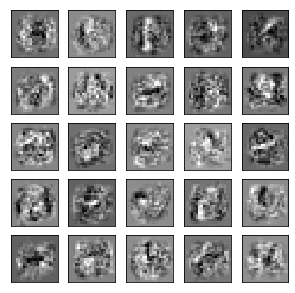

In [32]:
plot_hidden_layer(final_theta)
plt.show()